In [1]:
# uni_D83AE5_uni (Baseline)
#  {"Logloss": 0.04508655474248735, "ROCAUC": 0.9744860696967259}
import pandas as pd
# Importing necessary libraries for logistic regression and scaling
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, log_loss, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import log_loss
# Load the data
training_data = pd.read_csv('training_data.csv')

# Drop rows where BORROWER_ID is 'xNullx'
training_data = training_data[training_data['BORROWER_ID'] != 'xNullx']

# Shuffle the DataFrame
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True)

data_submission_example = pd.read_csv('data_submission_example.csv')


In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming training_data =  training_data.sample(n=10000, random_state=1)

# Filling NaN values with 0
training_data.fillna(0, inplace=True)

# Converting columns to numeric where possible
for col in training_data.columns:
    try:
        training_data[col] = pd.to_numeric(training_data[col], errors='ignore')
    except:
        continue

# Creating a sample target variable
training_data['TARGET_EVENT_BINARY'] = np.where(training_data['TARGET_EVENT'] == 'K', 1, 0)

In [3]:
lognormal_variables = [
    'CONTRACT_CREDIT_LOSS', 'CONTRACT_DEPT_SERVICE_TO_INCOME',
    'CONTRACT_INCOME', 'CONTRACT_INSTALMENT_AMOUNT', 'CONTRACT_INSTALMENT_AMOUNT_2',
    'CONTRACT_LOAN_AMOUNT', 'CONTRACT_MARKET_VALUE', 'CONTRACT_MORTGAGE_LENDING_VALUE', 
    'CONTRACT_LGD', 'CONTRACT_INCOME'
]
date_variables = ['CONTRACT_DATE_OF_LOAN_AGREEMENT', 'CONTRACT_MATURITY_DATE']

In [47]:
training_data['TARGET_EVENT_DAY_DATETIME'] = pd.to_datetime(training_data['TARGET_EVENT_DAY'])
training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'])

# Calculate the day difference
training_data['DAY_DIFF'] = (training_data['TARGET_EVENT_DAY_DATETIME'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days

# Create TARGET_EVENT_BINARY_2Y based on conditions
training_data['TARGET_EVENT_BINARY_2Y'] = np.where(
    (training_data['TARGET_EVENT'] == 'K') & 
    (training_data['DAY_DIFF'] <= 730) & 
    (training_data['DAY_DIFF'] >= 0), 
    1, 
    0
)
training_data['TARGET_EVENT_BINARY_1Y'] = np.where(
        (training_data['TARGET_EVENT'] == 'K') & 
        (training_data['DAY_DIFF'] <= 365) & 
        (training_data['DAY_DIFF'] >= 0), 
        1, 
        0
    )
training_data['TARGET_EVENT_BINARY_6M'] = np.where(
        (training_data['TARGET_EVENT'] == 'K') & 
        (training_data['DAY_DIFF'] <= 365//2) & 
        (training_data['DAY_DIFF'] >= 0), 
        1, 
        0
    )
training_data['TARGET_EVENT_BINARY_9M'] = np.where(
        (training_data['TARGET_EVENT'] == 'K') & 
        (training_data['DAY_DIFF'] <= 365//4*3) & 
        (training_data['DAY_DIFF'] >= 0), 
        1, 
        0
    )
training_data['TARGET_EVENT_BINARY_18M'] = np.where(
        (training_data['TARGET_EVENT'] == 'K') & 
        (training_data['DAY_DIFF'] <= 548) & 
        (training_data['DAY_DIFF'] >= 0), 
        1, 
        0
    )
# Drop the temporary 'DAY_DIFF' column if needed
training_data.drop('DAY_DIFF', axis=1, inplace=True)

In [5]:
# Identify numeric columns
numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()

# Identify target columns that shouldn't be in the X variables
excluded_keywords = ['TARGET', 'event', 'binary', 'DATE']

# Create lists for X variable columns and target column
X_columns = [col for col in numeric_columns if all(keyword.lower() not in col.lower() for keyword in excluded_keywords)]
y_column = 'TARGET_EVENT_BINARY_2Y' 
X_columns

['CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_CREDIT_LOSS',
 'CONTRACT_CURRENCY',
 'CONTRACT_DEPT_SERVICE_TO_INCOME',
 'CONTRACT_INCOME',
 'CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_INSTALMENT_AMOUNT_2',
 'CONTRACT_INTEREST_PERIOD',
 'CONTRACT_INTEREST_RATE',
 'CONTRACT_LGD',
 'CONTRACT_LOAN_AMOUNT',
 'CONTRACT_LOAN_CONTRACT_TYPE',
 'CONTRACT_LOAN_TO_VALUE_RATIO',
 'CONTRACT_MARKET_VALUE',
 'CONTRACT_MORTGAGE_LENDING_VALUE',
 'CONTRACT_MORTGAGE_TYPE',
 'CONTRACT_REFINANCED',
 'CONTRACT_RISK_WEIGHTED_ASSETS',
 'CONTRACT_TYPE_OF_INTEREST_REPAYMENT',
 'BORROWER_BIRTH_YEAR',
 'BORROWER_CITIZENSHIP',
 'BORROWER_COUNTRY',
 'BORROWER_COUNTY',
 'BORROWER_TYPE_OF_SETTLEMENT']

In [6]:
for var in date_variables:
    training_data[var+ '_JULIAN'] = pd.to_datetime(training_data[var], origin='julian', unit='D')

training_data['TIME_TO_MATURITY'] = (training_data['CONTRACT_MATURITY_DATE_JULIAN'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN']).dt.days

year_2018_date = pd.Timestamp('2018-01-01')
training_data['TIME_TO_MATURITY'] = (training_data['CONTRACT_MATURITY_DATE_JULIAN'] - year_2018_date).dt.days
training_data['ADJUSTED_TIME_TO_MATURITY'] = training_data['TIME_TO_MATURITY'].apply(lambda x: max(min(730, x),0))

In [7]:
# One-hot encode the 'CONTRACT_LOAN_TYPE' and 'CONTRACT_FREQUENCY_TYPE' columns
loan_type_dummies = pd.get_dummies(training_data['CONTRACT_LOAN_TYPE'], prefix='LOAN_TYPE', drop_first=True)
frequency_type_dummies = pd.get_dummies(training_data['CONTRACT_FREQUENCY_TYPE'], prefix='FREQ_TYPE', drop_first=True)

# Concatenate the original DataFrame with the one-hot encoded columns
training_data = pd.concat([training_data, loan_type_dummies, frequency_type_dummies], axis=1)

# Add the names of the one-hot encoded columns to X_columns
X_columns.extend(loan_type_dummies.columns)
X_columns.extend(frequency_type_dummies.columns)



In [8]:
training_data['BORROWER_LOAN_COUNT'] = training_data.groupby('BORROWER_ID')['BORROWER_ID'].transform('count')
training_data['LOAN_BORROWER_COUNT'] = training_data.groupby('CONTRACT_ID')['CONTRACT_ID'].transform('count')
training_data['TOTAL_LOAN_AMOUNT'] = training_data.groupby('BORROWER_ID')['CONTRACT_LOAN_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_1'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_2'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT_2'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT'] = training_data['TOTAL_INSTALLMENT_AMOUNT_1'] + training_data['TOTAL_INSTALLMENT_AMOUNT_2']
# training_data['AVERAGE_LOAN_AMOUNT'] = training_data['TOTAL_LOAN_AMOUNT'] / training_data['BORROWER_LOAN_COUNT']
# training_data['AVERAGE_LOAN_TERM'] = training_data.groupby('BORROWER_ID')['CONTRACT_MATURITY_DATE'].transform('mean')
# training_data['AVERAGE_INTEREST_RATE'] = training_data.groupby('BORROWER_ID')['CONTRACT_INTEREST_RATE'].transform('mean')
# training_data['MAX_DEBT_TO_INCOME'] = training_data.groupby('BORROWER_ID')['CONTRACT_DEPT_SERVICE_TO_INCOME'].transform('max')
# training_data['HAS_MULTIPLE_LOAN_TYPES'] = training_data.groupby('BORROWER_ID')['CONTRACT_LOAN_TYPE'].transform('nunique').apply(lambda x: 1 if x > 1 else 0)
# training_data['HAS_REFINANCED'] = training_data.groupby('BORROWER_ID')['CONTRACT_REFINANCED'].transform('max')

# # # training_data['RELATIVE_LOAN_AMOUNT'] = training_data['CONTRACT_LOAN_AMOUNT'] / training_data['TOTAL_LOAN_AMOUNT']
# training_data['IS_FIXED_RATE'] = training_data['CONTRACT_LOAN_CONTRACT_TYPE'].apply(lambda x: 1 if x == 'fixed' else 0)
# # Ez még nem tudom hogyan de hasznos lehet 
# # Assuming CONTRACT_MATURITY_DATE is a datetime object and 'current_date' is today's date
# # training_data['DAYS_TO_MATURITY'] = (training_data['CONTRACT_MATURITY_DATE'] - current_date).dt.days
X_columns.extend(['BORROWER_LOAN_COUNT', 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT','LOAN_BORROWER_COUNT'])
lognormal_variables.extend([ 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT'])

In [9]:
threshold = 0.85  # Set your own threshold
correlation_matrix = training_data[X_columns].corr()
# Get pairs of highly correlated features
highly_correlated_set = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_set.add(colname)

# Remove highly correlated features from X_columns
X_columns = [col for col in X_columns if col not in highly_correlated_set]
print('Variables removed:', highly_correlated_set)

Variables removed: {'BORROWER_COUNTRY', 'FREQ_TYPE_2f88e16c', 'CONTRACT_REFINANCED'}


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

def filter_2016(df1, df2, variables):
    # Create deep copies to avoid modifying original data
    df1_copy = df1.copy()
    df2_copy = df2.copy()

    # Convert to datetime format if not already
    df1_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'] = pd.to_datetime(df1_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'])
    df2_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'] = pd.to_datetime(df2_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'])
    
    # Filter data where CONTRACT_DATE_OF_LOAN_AGREEMENT is before 2016
    df1_filtered = df1_copy[df1_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'].dt.year < 2016]
    df2_filtered = df2_copy[df2_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'].dt.year < 2016]
    
    df1_filtered['CONTRACT_DATE_OF_LOAN_AGREEMENT'] = df1_filtered['CONTRACT_DATE_OF_LOAN_AGREEMENT'].apply(lambda x: x.toordinal())
    df2_filtered['CONTRACT_DATE_OF_LOAN_AGREEMENT'] = df2_filtered['CONTRACT_DATE_OF_LOAN_AGREEMENT'].apply(lambda x: x.toordinal())

    return df1_filtered, df2_filtered

def train_and_predict_two_halves(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    # Split the dataframe into two halves
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    half = len(df) // 2
    df1, df2 = df.iloc[:half], df.iloc[half:]
    #######################x########################
    # FILTERING TO 2016 MAKES IT A TINY BIT WORSE
    #######################x########################
    # df1, df2 = filter_2016(df1, df2, variables)
    # Scale the entire dataset using a single scaler
    X_scaled = scaler.fit_transform(df[variables])
    # X1_scaled = scaler.transform(df1[variables])
    # X2_scaled = scaler.transform(df2[variables])
    
    # Prepare target variables
    y = df[target]
    # y1 = df1[target]
    # y2 = df2[target]
    model1.fit(X_scaled, y)
    proba = model1.predict_proba(X_scaled)[:, 1]
    # y2_prob = model1.predict_proba(X2_scaled)[:, 1]
    # Train model1 on df1 and get probabilities on df2
    # model1.fit(X1_scaled, y1)
    # y2_prob = model1.predict_proba(X2_scaled)[:, 1]
    
    # # Train model2 on df2 and get probabilities on df1
    # model2.fit(X2_scaled, y2)
    # y1_prob = model2.predict_proba(X1_scaled)[:, 1]
    
    # Evaluate model1 on df2
    # print("Evaluation of Model 1 on df2:")
    # print("Classification Report:")
    # print(classification_report(y2, y2_prob >= 0.5))
    # print("Log Loss:")
    # print(log_loss(y2, y2_prob))
    # print("Confusion Matrix:")
    # print(confusion_matrix(y2, y2_prob >= 0.5))

    # # Evaluate model2 on df1
    # print("Evaluation of Model 2 on df1:")
    # print("Classification Report:")
    # print(classification_report(y1, y1_prob >= 0.5))
    # print("Log Loss:")
    # print(log_loss(y1, y1_prob))
    # print("Confusion Matrix:")
    # print(confusion_matrix(y1, y1_prob >= 0.5))
    
    # # Join the predicted probabilities
    # joined_prob = np.concatenate([y1_prob, y2_prob])
    
    return proba


In [11]:
import statsmodels.api as sm
def significant_features(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    X_scaled = scaler.fit_transform(df[variables])

    X = sm.add_constant(pd.DataFrame(X_scaled, columns=variables))
    y = df[target]

    # Fit the logistic regression model
    model = sm.Logit(y, X).fit()

    # Display the summary
    print(model.summary())
    # Get the p-values
    p_values = model.pvalues

    # Identify the non-significant variables
    non_significant_vars = p_values[p_values > 0.05].index.tolist()

    return model, non_significant_vars

In [12]:
import pandas as pd
import numpy as np

def cut_exponential_tails(df, target):
    df = df.copy()

    # Step 1: Estimate lambda for each row based on its 'target' value and 'ADJUSTED_TIME_TO_MATURITY'
    df['LAMBDA_ESTIMATE'] = -np.log(1 - df[target])/730

    # Step 2: Calculate new probabilities p_exp for each row based on its own lambda_estimate
    df[target] = 1 - np.exp(-df['LAMBDA_ESTIMATE'] * df['ADJUSTED_TIME_TO_MATURITY'])
    return df


def combined_probability(s):
    return 1 - np.prod(1 - s.values)

def create_submission_file(df_preds, target, example, filename='submission.csv', testing=False):
    # Filter the data to only include BORROWER_IDs that are in the submission example
    filtered_training_data = df_preds[df_preds['BORROWER_ID'].isin(example['BORROWER_ID'])]

    # Print warning if the row count is off
    if not testing and len(filtered_training_data) != 1564601:
        print('WARNING: The filtered data does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
    # Group by BORROWER_ID and calculate the combined probability

    #######################x########################
    #CUTTING TAILS DID NOT SEEM TO WORK
    #######################x########################
    # filtered_training_data = cut_exponential_tails(filtered_training_data, target)
    grouped_data = filtered_training_data.groupby('BORROWER_ID')[target].apply(combined_probability).reset_index()

    # Create the submission DataFrame
    df_submission = pd.DataFrame()
    df_submission['BORROWER_ID'] = grouped_data['BORROWER_ID']
    df_submission['PRED'] = grouped_data[target]
    print('Before centering:')
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    print('Centering probabilities...')
    # Center the probabilities around 1.48%
    desired_mean = 0.0148  # 1.48% as a decimal
    while (df_submission['PRED'].max() > 1 or df_submission['PRED'].min() < 0 or abs(df_submission['PRED'].mean() -0.0148) > 0.0005):
        # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
        df_submission['PRED'] = df_submission['PRED'].clip(lower=0, upper=1)
        # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

        current_mean = df_submission['PRED'].mean()
        adjustment_factor = desired_mean  - current_mean
        df_submission['PRED'] += adjustment_factor
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    # Save the submission file
    if  not testing and filename is not None:
        df_submission.to_csv(filename, index=False)
    print(f'Saved file: {filename}')
    # if abs(df_submission['PRED'].mean() -0.0148) > 0.0005:
    #    raise ValueError('WARNING: mean is bad')
        
    # Print warning if the row count is off
    if not testing and len(df_submission) != 1117674:
        print('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        
    return df_submission


In [13]:
def test_model_2y_1y(df, variables, target, model1=LogisticRegression(), model2=LogisticRegression()):
    df = df.copy()
    start_date = pd.Timestamp('2015-01-01')
    end_date = pd.Timestamp('2017-01-01')

    # Mask for rows with CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN between start_date and end_date
    mask_date_range = (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] >= start_date) & (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] <= end_date)

    df = df[mask_date_range]

    probs = train_and_predict_two_halves(
        df, 
        variables, 
        target, 
        model1=model1,
        model2=model2,
    )
    df['2Y-1Y-PROBS'] = probs
    
    test_data = pd.read_csv('./data/1y-test.csv')


    df_submission = create_submission_file(df, '2Y-1Y-PROBS', test_data, filename=None, testing=True)

    merged_df = pd.merge(test_data, df_submission, on='BORROWER_ID')
    true_labels = merged_df['TARGET_EVENT_BINARY_1Y']
    predicted_probs = merged_df['PRED']
    logloss = log_loss(true_labels, predicted_probs)

    print(f'Log loss: {logloss}')
        
    return logloss

In [14]:
model, non_significant_vars = significant_features(training_data, X_columns, y_column,LogisticRegression())

         Current function value: 0.016240
         Iterations: 35


c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Logit Regression Results                             
Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
Model:                              Logit   Df Residuals:                  1601613
Method:                               MLE   Df Model:                           49
Date:                    Thu, 02 Nov 2023   Pseudo R-squ.:                  0.6004
Time:                            22:20:42   Log-Likelihood:                -26011.
converged:                          False   LL-Null:                       -65100.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -10.2434      8.694     -1.178      0.239     -27.283       6.797
CONTRACT_CREDIT_INTERMED

In [15]:
non_significant_vars

['const',
 'CONTRACT_CREDIT_INTERMEDIARY',
 'BORROWER_COUNTY',
 'LOAN_TYPE_1f951336',
 'LOAN_TYPE_2f88e16c',
 'LOAN_TYPE_47693941',
 'LOAN_TYPE_5a06241e',
 'LOAN_TYPE_694cbaee',
 'LOAN_TYPE_69f70539',
 'LOAN_TYPE_7e2065f4',
 'LOAN_TYPE_83910425',
 'LOAN_TYPE_8fe006f1',
 'LOAN_TYPE_955ae3ef',
 'LOAN_TYPE_95c4f8fb',
 'LOAN_TYPE_b503a0de',
 'LOAN_TYPE_cde77491',
 'LOAN_TYPE_cf07c2dd',
 'LOAN_TYPE_d3aaffde',
 'LOAN_TYPE_eab72d7a',
 'LOAN_TYPE_f792971b',
 'FREQ_TYPE_89efd382',
 'FREQ_TYPE_bd092d5a']

In [16]:
# X_columns_significant = [col for col in X_columns if col not in non_significant_vars]
# X_columns_significant.append('CONTRACT_INSTALMENT_AMOUNT_2')

In [17]:
X_columns.remove('CONTRACT_CREDIT_INTERMEDIARY')
X_columns.remove('BORROWER_COUNTY')

In [35]:
predicted_probs = 'LOGISTIC_REG'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    y_column, 
    model1=LogisticRegression(max_iter=400, C=0.5, random_state=42),
)
# 0.015985249571782673
training_data[predicted_probs] = probs
print(probs.mean())
submission = create_submission_file(training_data, predicted_probs, data_submission_example, filename='./predictions/logistic-regression-one-model.csv')

0.006785876080349979
Before centering:
0.9978858840423693 8.548717289613705e-15 0.006057291039756555
Centering probabilities...
1.0 0.008742718377039292 0.014800000000000002
Saved file: ./predictions/logistic-regression-one-model.csv


c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

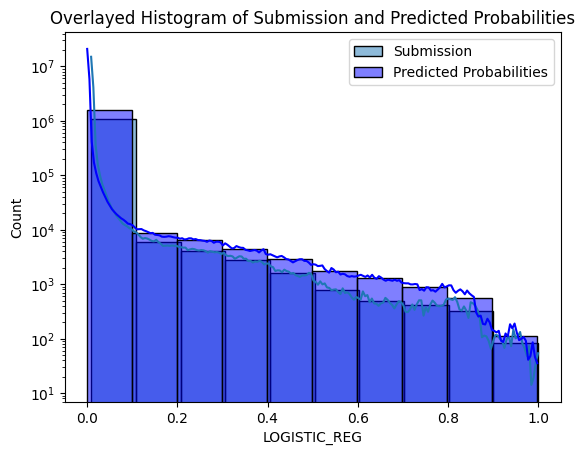

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(submission, bins=10, kde=True, label='Submission', alpha=0.5,color='red')

# Plot for 'training_data[predicted_probs]' overlaid on the same chart
sns.histplot(training_data[predicted_probs], bins=10, kde=True, label='Predicted Probabilities', alpha=0.5, color='blue')

# Set y-scale to log to accommodate wide value ranges
plt.yscale('log')

# Add a legend to distinguish the histograms
plt.legend()

# Add a title to the chart
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')

# Show the plot
plt.show()


In [48]:
print("2Y-1Y")
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY_1Y', 
    model1=LogisticRegression(max_iter=400, C=0.5, random_state=42),
)
training_data['LOGISTIC_REG_1Y'] = probs
print("2Y-18M")
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY_18M', 
    model1=LogisticRegression(max_iter=400, C=0.5, random_state=42),
)
training_data['LOGISTIC_REG_18M'] = probs

print("2Y-9M")
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY_9M', 
    model1=LogisticRegression(max_iter=400, C=0.5, random_state=42),
)
training_data['LOGISTIC_REG_9M'] = probs
print("2Y-6M")
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY_6M', 
    model1=LogisticRegression(max_iter=400, C=0.5, random_state=42),
)
training_data['LOGISTIC_REG_6M'] = probs

2Y-18M


In [64]:
lambdas = -np.log(1 - training_data['LOGISTIC_REG_1Y'])/1
probs_1y = 1 - np.exp(-2 * lambdas)

lambdas = -np.log(1 - training_data['LOGISTIC_REG_18M'])/1.5
probs_18m = 1 - np.exp(-2 * lambdas)

lambdas = -np.log(1 - training_data['LOGISTIC_REG_9M'])/0.75
probs_9m = 1 - np.exp(-2 * lambdas)

lambdas = -np.log(1 - training_data['LOGISTIC_REG_6M'])/0.5
probs_6m = 1 - np.exp(-2 * lambdas)

In [70]:
training_data['18M_PROBA'] = probs_18m
training_data['9M_PROBA'] = probs_9m
training_data['6M_PROBA'] = probs_6m
training_data['1Y_PROBA'] = probs_1y

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

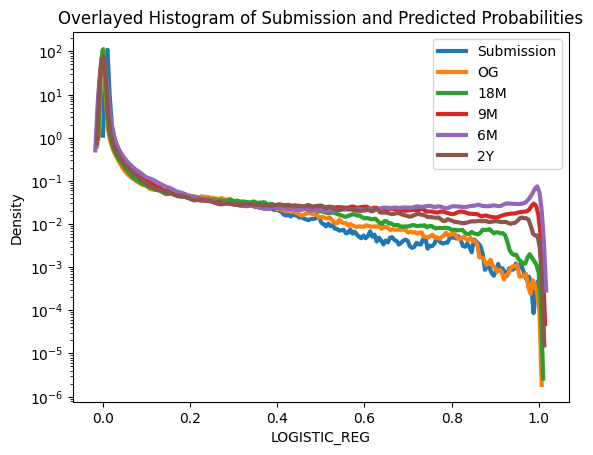

In [71]:
sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)
sns.kdeplot(training_data['18M_PROBA'], label='18M', lw=3, alpha=1)
sns.kdeplot(training_data['9M_PROBA'], label='9M', lw=3, alpha=1)
sns.kdeplot(training_data['6M_PROBA'], label='6M', lw=3, alpha=1)
sns.kdeplot(training_data['1Y_PROBA'], label='2Y', lw=3, alpha=1)
plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [73]:
# submission_1y_2y = create_submission_file(training_data, '1Y_PROBA', data_submission_example, filename='./predictions/tmp.csv')
# submission_1y_18m = create_submission_file(training_data, '18M_PROBA', data_submission_example, filename='./predictions/tmp.csv')
submission_1y_9m = create_submission_file(training_data, '9M_PROBA', data_submission_example, filename='./predictions/logistic-reg-9m-2y.csv')
# submission_1y_6m = create_submission_file(training_data, '6M_PROBA', data_submission_example, filename='./predictions/tmp.csv')

Before centering:
0.9999999263775705 2.275957200481571e-14 0.012557540025643158
Centering probabilities...
1.0 0.002242561959868836 0.014799999999999999
Saved file: ./predictions/logistic-reg-9m-2y.csv


In [25]:
# submission_1y_2y = create_submission_file(training_data, '2Y_PROBA', data_submission_example, filename='./predictions/logistic-regression-2y-1y.csv')

Before centering:
0.9999955305137177 1.709743457922741e-14 0.010279658216347512
Centering probabilities...
1.0 0.00452043496900666 0.014800000000000002
Saved file: ./predictions/logistic-regression-2y-1y.csv


c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

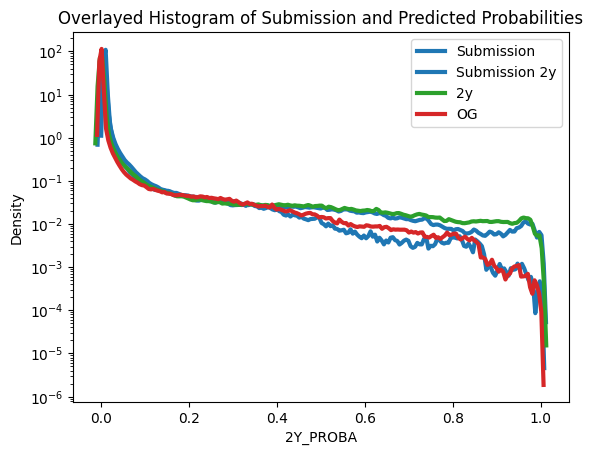

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(submission_1y_2y, label='Submission 2y', lw=3, alpha=1)
sns.kdeplot(training_data['2Y_PROBA'], label='2y', lw=3, alpha=1)
sns.kdeplot(training_data[predicted_probs], label='OG', lw=3, alpha=1)

# Show the plot with a legend
plt.legend()

# Set y-scale to log to accommodate wide value ranges
plt.yscale('log')

# Add a legend to distinguish the histograms
plt.legend()

# Add a title to the chart
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')

# Show the plot
plt.show()


In [29]:
predicted_probs = 'RANDOM_FOREST'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    y_column, 
    model1=RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42),
)
training_data[predicted_probs] = probs


c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

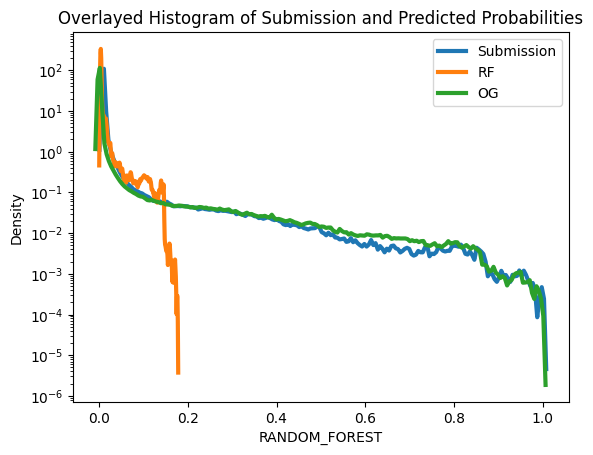

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['RANDOM_FOREST'], label='RF', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)

# Show the plot with a legend
plt.legend()

# Set y-scale to log to accommodate wide value ranges
plt.yscale('log')

# Add a legend to distinguish the histograms
plt.legend()

# Add a title to the chart
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')

# Show the plot
plt.show()


In [32]:
submission_rf = create_submission_file(training_data, 'RANDOM_FOREST',data_submission_example, filename='./predictions/random-forrest-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv')

Before centering:
0.8675531219873692 0.0026670801246374554 0.008599946438351795
Centering probabilities...
0.8737531755490174 0.008867133686285661 0.014800000000000002
Saved file: ./predictions/random-forrest-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv


c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

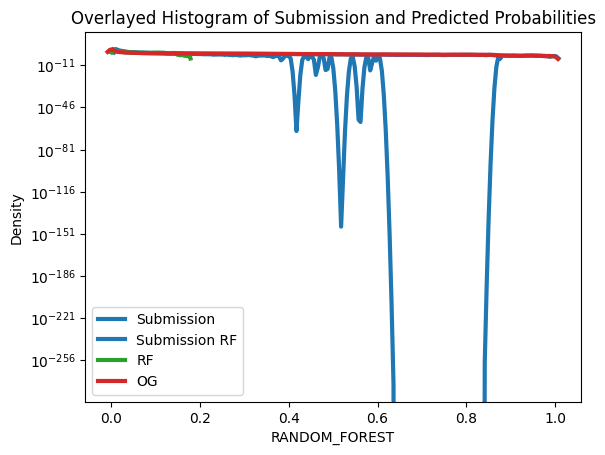

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(submission, label='Submission', lw=3, alpha=1)

sns.kdeplot(submission_rf, label='Submission RF', lw=3, alpha=1)
sns.kdeplot(training_data['RANDOM_FOREST'], label='RF', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)

# Show the plot with a legend
plt.legend()

# Set y-scale to log to accommodate wide value ranges
plt.yscale('log')

# Add a legend to distinguish the histograms
plt.legend()

# Add a title to the chart
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')

# Show the plot
plt.show()


In [ ]:
predicted_probs = 'GRADIENT_BOOSTING_CLASSIFIER'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    y_column, 
    model1=GradientBoostingClassifier(random_state=42),
    model2=GradientBoostingClassifier(random_state=42),
)
training_data[predicted_probs] = probs
submission = create_submission_file(training_data, predicted_probs,data_submission_example, filename='./predictions/gbc-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv')

In [ ]:
predicted_probs = 'XGBOOST'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    y_column, 
    model1= xgb.XGBClassifier(max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    model2= xgb.XGBClassifier(max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss'),
)
training_data[predicted_probs] = probs
submission = create_submission_file(training_data, predicted_probs, data_submission_example, filename='./predictions/xgboost-max_depth=3-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv')

Evaluation of Model 1 on df2:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    795431
           1       0.77      0.67      0.72      5401

    accuracy                           1.00    800832
   macro avg       0.88      0.83      0.86    800832
weighted avg       1.00      1.00      1.00    800832

Log Loss:
0.008920031130332217
Confusion Matrix:
[[794339   1092]
 [  1781   3620]]
Evaluation of Model 2 on df1:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    795363
           1       0.76      0.65      0.70      5468

    accuracy                           1.00    800831
   macro avg       0.88      0.83      0.85    800831
weighted avg       1.00      1.00      1.00    800831

Log Loss:
0.00899427534801325
Confusion Matrix:
[[794243   1120]
 [  1894   3574]]
Centering probabilities...
0.9933470937188168 0.011253558355142607 0.0147

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

models =  [
    (LogisticRegression(max_iter=400, penalty=None, C=1.0, random_state=42),
     LogisticRegression(max_iter=400, penalty=None, C=1.0, random_state=42)),
    
   (LogisticRegression(max_iter=400, penalty=None, C=0.5, random_state=42),
     LogisticRegression(max_iter=400, penalty=None, C=0.5, random_state=42)),
]

best_logloss = 100
best_models = None
for model in models:

    logloss = test_model_2y_1y(
        training_data, 
        X_columns, 
        'TARGET_EVENT_BINARY_1Y',
        model1=model[0],
        model2=model[1],
    )
    if logloss < best_logloss:
        best_logloss = logloss
        best_models = model
    print(model[0])
    print('Logloss is ', logloss)
    print('-----------------------------------------')

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Evaluation of Model 1 on df2:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509478
           1       0.60      0.39      0.47      5071

    accuracy                           0.99    514549
   macro avg       0.79      0.69      0.73    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.020154686217490652
Confusion Matrix:
[[508136   1342]
 [  3093   1978]]
Evaluation of Model 2 on df1:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509480
           1       0.60      0.40      0.48      5069

    accuracy                           0.99    514549
   macro avg       0.80      0.70      0.74    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.02041090972095113
Confusion Matrix:
[[508121   1359]
 [  3032   2037]]
Centering probabilities...
1.0 0.0027108450789681583 0.014800000000000004

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\takat\AppData\Local\Programs\Python

Evaluation of Model 1 on df2:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509478
           1       0.60      0.39      0.47      5071

    accuracy                           0.99    514549
   macro avg       0.79      0.69      0.73    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.020154686217490652
Confusion Matrix:
[[508136   1342]
 [  3093   1978]]
Evaluation of Model 2 on df1:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509480
           1       0.60      0.40      0.48      5069

    accuracy                           0.99    514549
   macro avg       0.80      0.70      0.74    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.02041090972095113
Confusion Matrix:
[[508121   1359]
 [  3032   2037]]
Centering probabilities...
1.0 0.0027108450789681583 0.014800000000000004

In [ ]:
groups_by_size = {}

# Initialize a dictionary to hold covariance matrices by group size
cov_matrices_by_size = {}

# Group by 'BORROWER_ID' and iterate through the first 100 groups
for idx, (name, group) in enumerate(training_data.groupby('BORROWER_ID')):
    if idx % 100 == 0: 
        print('At index', idx)
        
    if idx == 50000:
        break
    
    # Sort the group by CONTRACT_DATE_OF_LOAN_AGREEMENT
    group = group.sort_values(by='CONTRACT_DATE_OF_LOAN_AGREEMENT')
    
    group_size = len(group)
    if group_size not in groups_by_size:
        groups_by_size[group_size] = []
        
    groups_by_size[group_size].append(group)

# Initialize a new dictionary to hold the merged DataFrames by size
merged_groups_by_size = {}

for size, dfs in groups_by_size.items():
    # Merge all DataFrames of the same size into a single DataFrame
    merged_df = pd.concat(dfs, ignore_index=True)
    # Store the merged DataFrame in the new dictionary
    merged_groups_by_size[size] = merged_df

# Now, merged_groups_by_size contains the merged DataFrames categorized by group size


In [ ]:
import json
import numpy as np
import pandas as pd

# Your code to generate groups_by_size and merged_groups_by_size

cov_matrices_by_size = {}

for size, merged_df in merged_groups_by_size.items():
    if size > 1:  # Covariance matrix for single-element arrays doesn't make sense
        try:
            cov_matrix = np.cov(merged_df['TARGET_EVENT_BINARY'].values.reshape(size,-1))
            if not np.isnan(cov_matrix).any():  # Check for NaN values
                cov_matrices_by_size[size] = cov_matrix.tolist()  # Convert numpy array to list for JSON serialization
        except Exception as e:
            print(f"An error occurred while calculating the covariance matrix for size {size}: {e}")

# Ensure that the dictionary contains only JSON-serializable items
serializable_cov_matrices_by_size = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in cov_matrices_by_size.items()}

# Save to JSON
with open('./data/cov_matrices_by_size.json', 'w') as f:
    json.dump(serializable_cov_matrices_by_size, f)


C:\Users\takat\AppData\Local\Temp\ipykernel_13332\2391036120.py:12: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(merged_df['TARGET_EVENT_BINARY'].values.reshape(size,-1))
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [ ]:
cov_matrices_by_size

{2: [[0.005868589752778426, -3.2357827075016176e-05],
  [-3.2357827075016176e-05, 0.005451716043799604]],
 3: [[0.007337144521720125, -2.6009019928111114e-05, -2.6009019928111046e-05],
  [-2.6009019928111114e-05, 0.003507502116019551, -1.2385247584814735e-05],
  [-2.6009019928111046e-05, -1.2385247584814735e-05, 0.003507502116019557]],
 4: [[0.0023364421983921592,
   -1.3695440787761734e-05,
   -5.478176315104693e-06,
   -8.217264472657053e-06],
  [-1.3695440787761734e-05,
   0.005820562334798763,
   -1.3695440787761748e-05,
   -2.054316118164268e-05],
  [-5.478176315104693e-06,
   -1.3695440787761748e-05,
   0.0023364421983921558,
   -8.217264472657026e-06],
  [-8.217264472657053e-06,
   -2.054316118164268e-05,
   -8.217264472657026e-06,
   0.003500554665351909]],
 8: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 

In [ ]:
# Save to JSON
import json

with open('cov_matrices_by_size.json', 'w') as f:
    json.dump(cov_matrices_by_size, f)